### 20. Proces M/M/1 - zależność od czasu

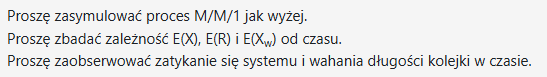

In [1]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [29]:
class QueueingSystem:
    def __init__(self, lambdaA, lambdaS, server_capacities=[-1], n_events=2_000): # -1 -> inf
        self.lambdaA = lambdaA # arrival rate
        self.lambdaS = lambdaS # service rate
        self.muA = 1 / lambdaA # mean inter-arrival time
        self.muS = 1 / lambdaS # mean service time

        self.n_servers = len(server_capacities)
        self.server_capacities = server_capacities
        self.n_events = n_events

        self.queues = [deque() for _ in range(self.n_servers)]
        self.server_busy_until = [0] * self.n_servers
        self.current_time = 0

        # \beta is the scale parameter, which is the inverse of the rate parameter \lambda = 1/\beta. 
        # The rate parameter is an alternative, widely used parameterization of the exponential distribution
        self.arrival_times = deque(np.cumsum(np.random.exponential(self.muA, self.n_events)))
        self.service_times = deque(np.random.exponential(self.muS, self.n_events))

        self.results = []
        self.data = {
            'time': [],
            'E(R)': [],
            'E(X)': [],
            'E(Xw)': [],
        }

    def simulate(self):
        while self.arrival_times or any(len(queue) > 0 for queue in self.queues):
            self.handle_depatrure()

            while self.arrival_times and self.arrival_times[0] <= self.current_time: # 2x while self.arrival?
                self.current_time = self.arrival_times.popleft()
                service_time = self.service_times.popleft()
                self.handle_arrival(self.current_time, service_time)
            
            next_event_times = []
            for busy_until in self.server_busy_until:
                if busy_until > self.current_time:
                    next_event_times.append(busy_until)
            if self.arrival_times:
                next_event_times.append(self.arrival_times[0])

            

            if next_event_times:
                self.current_time = min(next_event_times)
            else:
                break

            self.data['time'].append(self.current_time)
            self.data['E(R)'].append(self.calculate_average_time_in_system())
            self.data['E(X)'].append(self.calculate_average_number_in_system())
            self.data['E(Xw)'].append(self.calculate_average_number_in_queue())

    def handle_arrival(self, arrival_time, service_time):
        # all servers are busy, add customer to the shortest queue
        queue_lengths = [len(q) for q in self.queues]
        min_queue_length = min(queue_lengths)
        min_queue_index = queue_lengths.index(min_queue_length)

        capacity = self.server_capacities[min_queue_index]
        if capacity == -1 or len(self.queues[min_queue_index]) < capacity:
            self.queues[min_queue_index].append((arrival_time, service_time))
        else:
            # reject the customer, queue is full
            pass

    def handle_depatrure(self):
        for i in range(self.n_servers):
            if self.server_busy_until[i] <= self.current_time:
                if self.queues[i]:
                    arrival_time, service_time = self.queues[i].popleft()
                    start_time = max(arrival_time, self.current_time)
                    self.server_busy_until[i] = start_time + service_time
                    self.results.append({
                        'Arrival time': arrival_time,
                        'Service start time': start_time,
                        'Service time': service_time,
                        'Departure time': start_time + service_time,
                        'Server': i
                    })

    def calculate_average_time_in_system(self):
        if self.results == []:
            return 0
        total_time_in_system = 0
        for result in self.results:
            time_in_system = result['Departure time'] - result['Arrival time']
            total_time_in_system += time_in_system
        average_time_in_system = total_time_in_system / len(self.results)
        return average_time_in_system

    def calculate_arrival_rate(self):
        total_arrivals = len(self.results)
        total_time = self.current_time
        arrival_rate = total_arrivals / total_time
        return arrival_rate

    def calculate_average_number_in_system(self):
        event_times = []
        for result in self.results:
            event_times.append((result['Arrival time'], 'arrival'))
            event_times.append((result['Departure time'], 'departure'))
        event_times.sort()

        num_in_system = 0
        last_event_time = 0
        area_under_curve = 0

        for time, event_type in event_times:
            time_interval = time - last_event_time
            area_under_curve += num_in_system * time_interval
            last_event_time = time

            if event_type == 'arrival':
                num_in_system += 1
            else:
                num_in_system -= 1

        total_time = self.current_time
        average_number_in_system = area_under_curve / total_time
        return average_number_in_system
    
    def calculate_average_number_in_queue(self):
        queue_events = []
        for result in self.results:
            arrival_time = result['Arrival time']
            start_time = result['Service start time']
            # only add to queue if the task actually waited
            if start_time > arrival_time:
                queue_events.append((arrival_time, 'queue_enter'))
                queue_events.append((start_time, 'queue_exit'))

        queue_events.sort()
        num_in_queue = 0
        last_event_time = 0
        area_under_curve = 0

        for time, event_type in queue_events:
            time_interval = time - last_event_time
            area_under_curve += num_in_queue * time_interval
            last_event_time = time

            if event_type == 'queue_enter':
                num_in_queue += 1
            else:
                num_in_queue -= 1

        total_time = self.current_time
        average_number_in_queue = area_under_curve / total_time
        return average_number_in_queue
    
    def get_data(self):
        return self.data

λA: 0.06666666666666667 λS: 0.1
λA: 0.06666666666666667 λS: 0.06666666666666667
λA: 0.06666666666666667 λS: 0.05


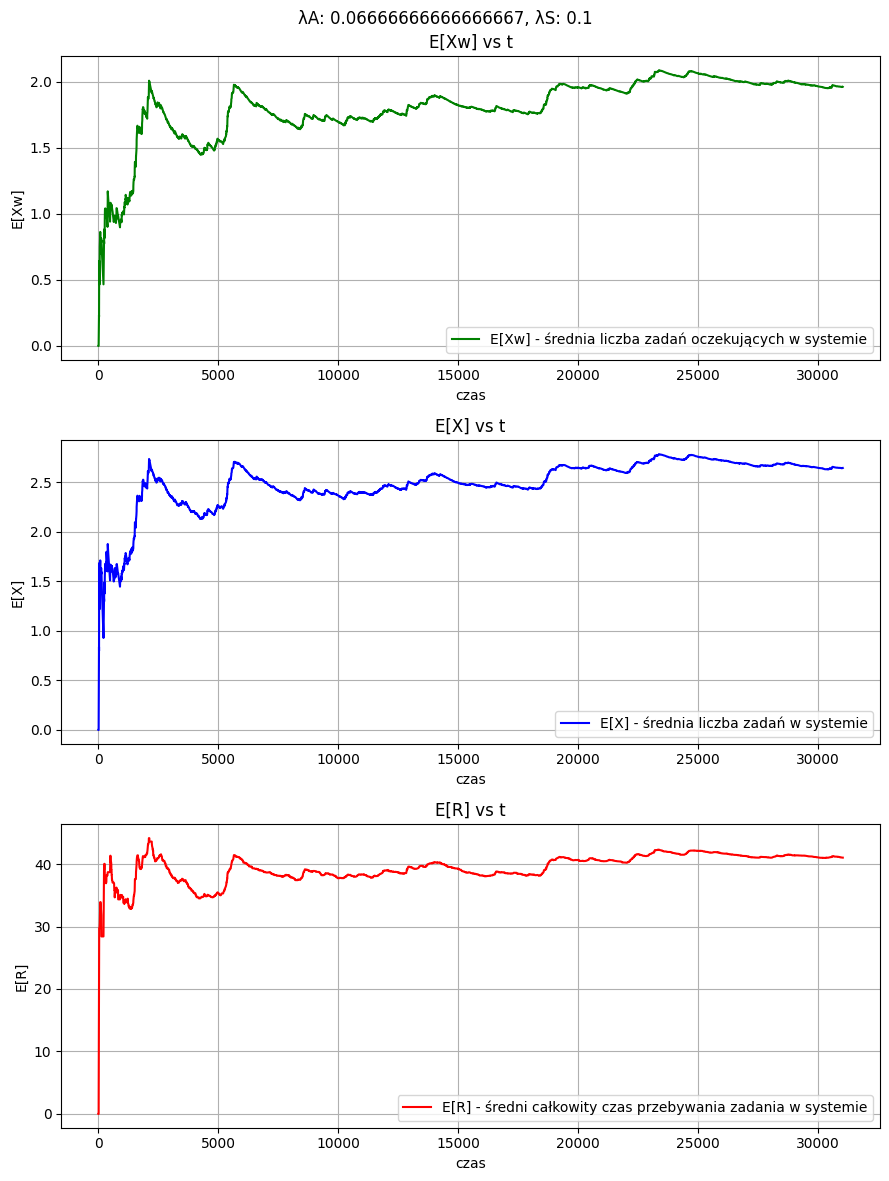

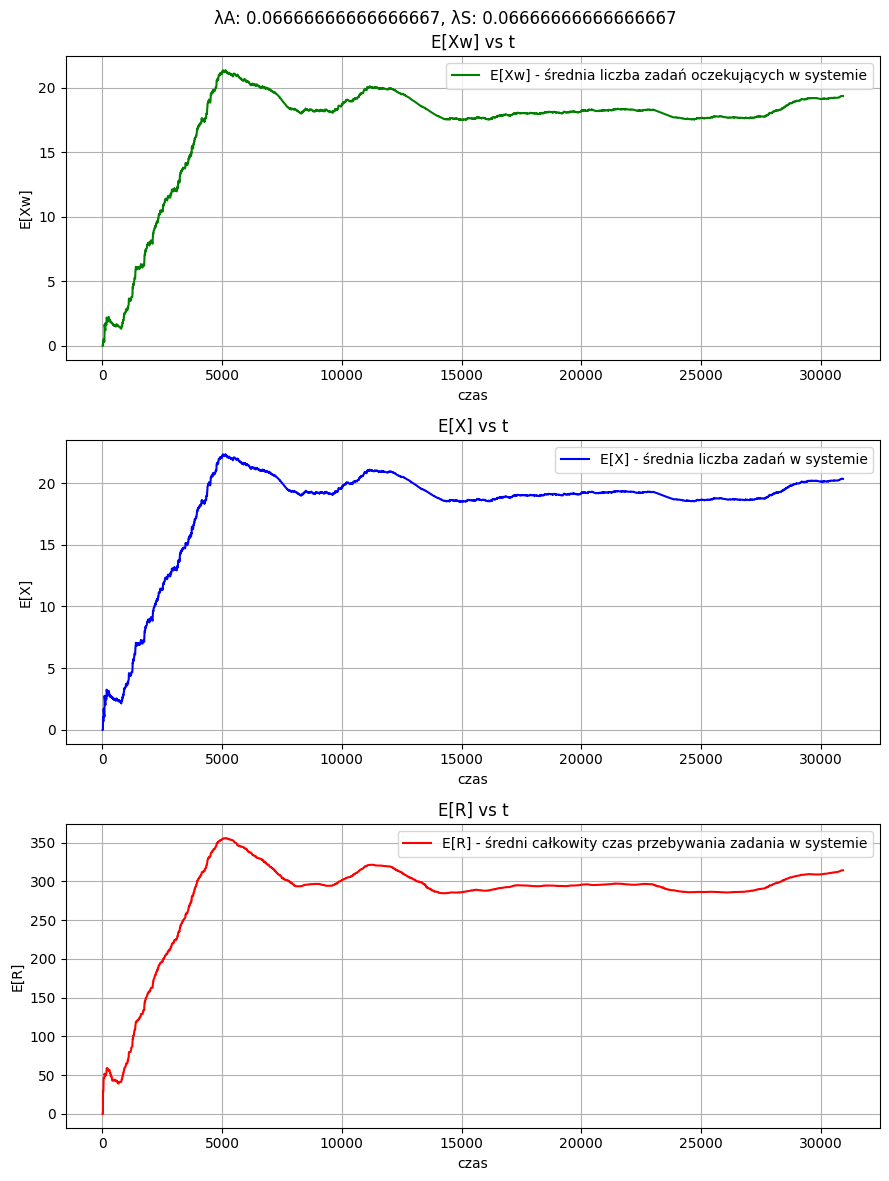

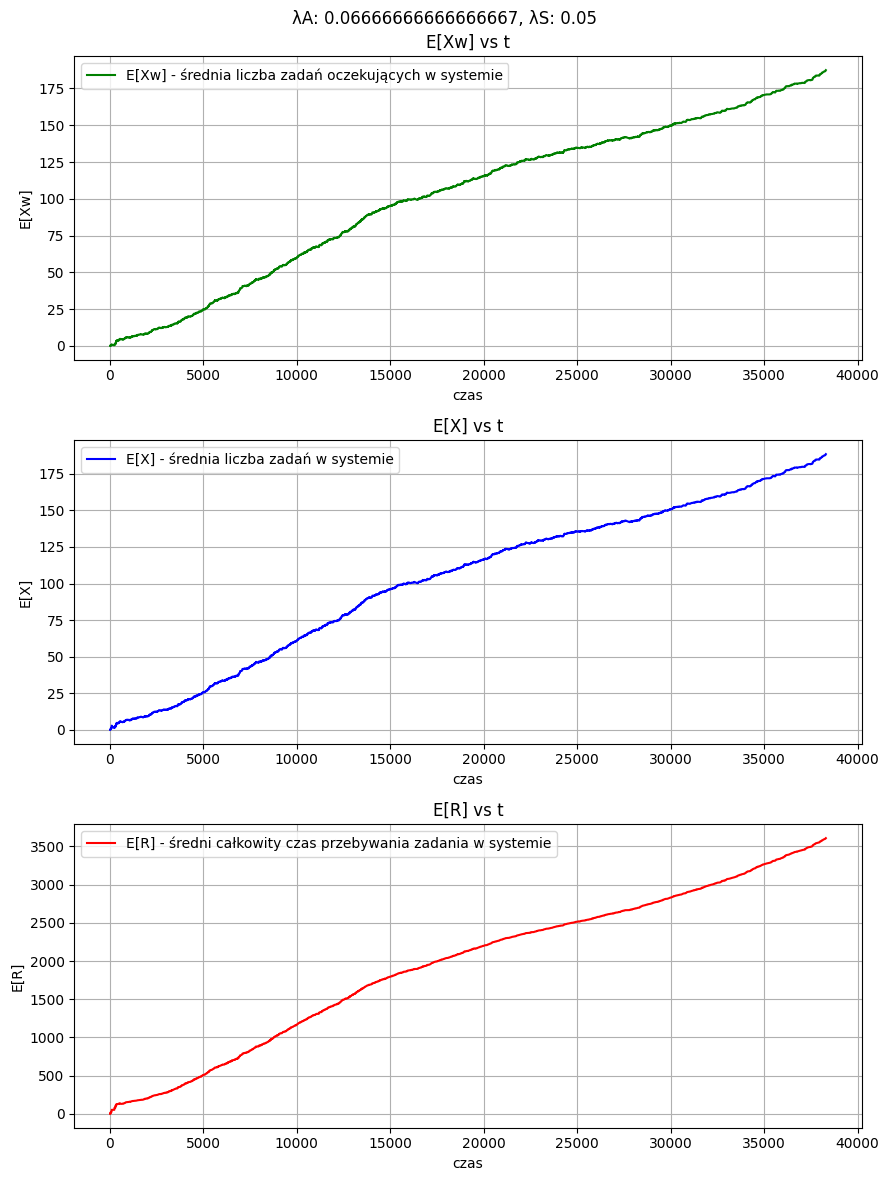

In [30]:
lambdaA = 1/15 # tempo nadchodzenia zadań
lambdaS = [1/10, 1/15, 1/20] # tempa obsługi zadań 

E_X_values = []
E_R_values = []
E_Xw_values = []
times = []

for lS in lambdaS:
    mm1 = QueueingSystem(lambdaA, lS)
    print("λA:", lambdaA, "λS:", lS)
    mm1.simulate()
    data = mm1.get_data()
    E_X_values = data['E(X)']
    E_R_values = data['E(R)']
    E_Xw_values = data['E(Xw)']
    times = data['time']

    # --- 

    plt.figure(figsize=(9, 12))
    plt.suptitle(f'λA: {lambdaA}, λS: {lS}')

    plt.subplot(3, 1, 1)
    plt.plot(times, E_Xw_values, 'g-', label='E[Xw] - średnia liczba zadań oczekujących w systemie')
    plt.xlabel('czas')
    plt.ylabel('E[Xw]')
    plt.title('E[Xw] vs t')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(times, E_X_values, 'b-', label='E[X] - średnia liczba zadań w systemie')
    plt.xlabel('czas')
    plt.ylabel('E[X]')
    plt.title('E[X] vs t')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(times, E_R_values, 'r-', label='E[R] - średni całkowity czas przebywania zadania w systemie')
    plt.xlabel('czas')
    plt.ylabel('E[R]')
    plt.title('E[R] vs t')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

Dla λA < λS (wykresy 1-3):
- Wszystkie trzy zmienne przyjmują wartości bliskie zera. Wartości te się zmieniają, ale ogólnie, utrzymują się na stałym poziomie (który osiągają dość szybko).

Dla λA = λS (wykresy 4-6):
- Wszystkie trzy zmienne przyjmują nadal dość niskie wartości, ale wyższe niż w pierwszym przypadku. Wartości te się zmieniają, ale ogólnie, po pewnym czasie (dłuższym niż w pierwszym przypadku), utrzymują się na stałym poziomie.

Dla λA > λS (wykresy 7-9):
- Wszystkie trzy zmienne rosną do nieskończoności. Oczywiście nie widać tego na moich wykresach, ponieważ musiałem kiedyś zakończyć symulację, ale ponieważ tempo nadchodzenie zadań jest większe niż tempo ich wykonywania, będą się tworzyły coraz większe kolejki. 

Co ciekawe, wartości z wykresów 4-6 oraz 7-9 początkowo rosną z podobną prędkością - przykładowo, E[Xw] na wykresie 7 dla czasu 5000 wynosi ~25, a na wykresie 4 wynosi ~21. Różnica jest taka, że na wykresie 4 wartości stabilizują się niedługo później, a na 7 wiecznie rosną.